In [135]:
import matplotlib.pyplot as plt
import random
import time
import math
import numpy as np

In [136]:
NUM_CENTROIDS = 3
CENTROIDS = []
COORD_RANGE = (-10, 10)
NUM_POINTS_PER_CLUSTER = 300
POINTS = []
SPREAD = 5
COLORS = ['green', 'purple', 'orange']

# Plain Python implementation

In [137]:
for _ in range(NUM_CENTROIDS):
    CENTROIDS.append([random.uniform(*COORD_RANGE), random.uniform(*COORD_RANGE)])

In [138]:
CENTROIDS

[[-2.209223881408258, -7.952650688555705],
 [0.9300968541041303, 7.9564218178737],
 [4.274856546426534, -0.3971410420897179]]

In [139]:
# generate 300 points per centroid
# with a probability of more likely to be closed to their centroid
# Normal Distribution => data points will be distributed near mean

# random.gauss(mu, sigma)
# mu -> mean or center of the dist
# sigma -> standard deviation or spread
for cx, cy in CENTROIDS:
    for _ in range(NUM_POINTS_PER_CLUSTER):
        x = random.gauss(cx, SPREAD)
        y = random.gauss(cy, SPREAD)
        POINTS.append((x ,y))

In [140]:
len(POINTS)

900

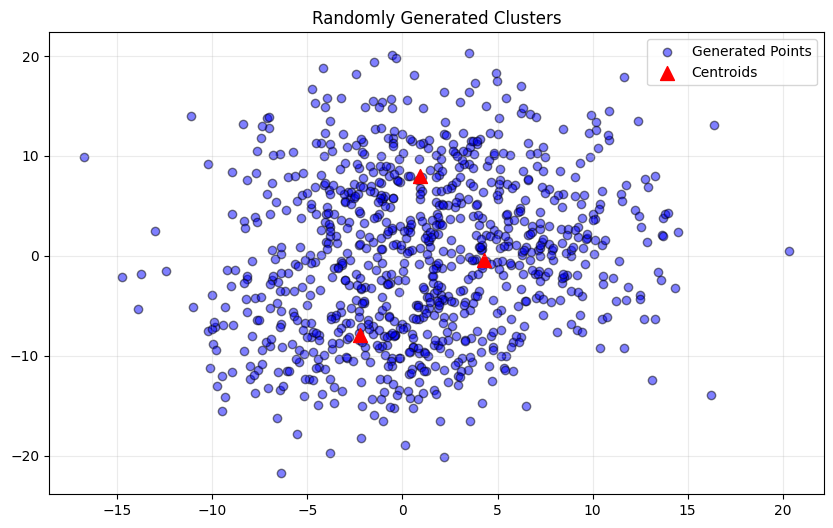

In [141]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(*zip(*POINTS), color='blue', alpha=0.5, edgecolors='k', label="Generated Points")
ax.scatter(*zip(*CENTROIDS), color='red', marker='^', s=100, label="Centroids")
ax.set_title('Randomly Generated Clusters')
ax.legend()
ax.grid(True, alpha=0.25)

plt.savefig('./data/randomly_generated_clusters.png')

In [142]:
# calculate distance between a point and centroid
# 2 Points: P(x1, y1) and Q(x2, y2)
# Euclidean Distance => sqrt((x2 - x1)^2 + (y2 - y1)^2)
# ||v|| norm: length of the vector but does not include direction
def euclidean_distance(point_1, point_2):
    return math.sqrt((point_2[0] - point_1[0])**2 + (point_2[1] - point_1[1])**2)


# assign each point to the closest centroid based on euclidean_distance
# iterate through all points
def assign_points_to_cluster(points, centroids):
    clusters = [[] for _ in centroids]

    for point in points:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        # min(distances) -> smallest distance
        # .index(val) -> returns the index of that min val (closest)
        closest_index = distances.index(min(distances))
        clusters[closest_index].append(point)

    return clusters

In [143]:
# compute new centroids
# update centroids by computing mean of all points in that cluster
def compute_new_centroids(clusters):
    new_centroids = []

    for cluster in clusters:
        if cluster:
            mean_x = sum(p[0] for p in cluster) / len(cluster)
            mean_y = sum(p[1] for p in cluster) / len(cluster)
            new_centroids.append((mean_x, mean_y))
        else:
            new_centroids.append((random.uniform(*COORD_RANGE), random.uniform(*COORD_RANGE)))

    return new_centroids

In [144]:
# Basic K-mean algorithm
# Iterate assign_points_to_cluster and compute_new_centroids
# Stop if centroids don’t change significantly
def k_means(points, k, max_iters=500):
    centroids = random.sample(points, k)

    for _ in range(max_iters):
        clusters = assign_points_to_cluster(points=points, centroids=centroids)
        new_centroids = compute_new_centroids(clusters=clusters)

        centroids = new_centroids

    return centroids, clusters

In [145]:
start_time = time.time()

final_centroids, final_clusters = k_means(points=POINTS, k=NUM_CENTROIDS, max_iters=500)

end_time = time.time()
total_time = end_time- start_time
print(f'K-means time taken: {total_time:.4f}')

K-means time taken: 0.3013


In [146]:
for i in range(len(final_clusters)):
    print(f'Points in cluster_{i+1}: {len(final_clusters[i])}')

Points in cluster_1: 348
Points in cluster_2: 314
Points in cluster_3: 238


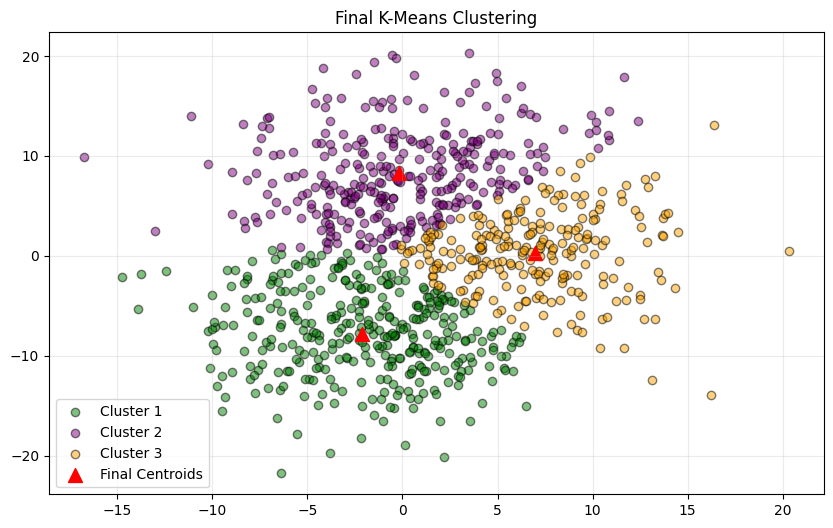

In [147]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, cluster in enumerate(final_clusters):
    ax.scatter(*zip(*cluster), color=COLORS[i], alpha=0.5, edgecolors='k', label=f"Cluster {i+1}")
ax.scatter(*zip(*final_centroids), color='red', marker='^', s=100, label="Final Centroids")
ax.set_title("Final K-Means Clustering")
ax.legend()
ax.grid(True, alpha=0.25)

plt.savefig('./data/kmeans_final_clusters.png')

# Vectorize implementation using Numpy

In [148]:
NUM_CENTROIDS = 3
COORD_RANGE = (-10, 10)
CENTROIDS = np.random.uniform(COORD_RANGE[0], COORD_RANGE[1], size=(NUM_CENTROIDS, 2))
NUM_POINTS_PER_CLUSTER = 300
SPREAD = 5
POINTS = np.concatenate([
    # loc = center (mean)
    # scale = spread (std deviation or sigma)
    # size = (m, n)
    #   m = number of points
    #   n = (x, y)
    np.random.normal(loc=centroid, scale=SPREAD, size=(NUM_POINTS_PER_CLUSTER, 2))
    for centroid in CENTROIDS
])

In [149]:
len(POINTS)

900

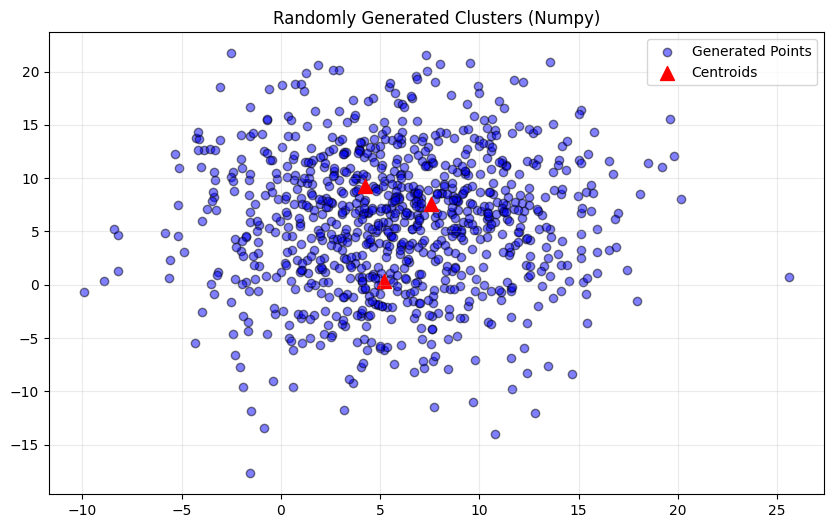

In [150]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(POINTS[:, 0], POINTS[:, 1], color='blue', alpha=0.5, edgecolors='k', label="Generated Points")
ax.scatter(CENTROIDS[:, 0], CENTROIDS[:, 1], color='red', marker='^', s=100, label="Centroids")
ax.set_title('Randomly Generated Clusters (Numpy)')
ax.legend()
ax.grid(True, alpha=0.25)

plt.savefig('./data/randomly_generated_clusters_np.png')

In [151]:
# distances between all points and centroids
# np.linalg.norm -> computes magnitude of a vector
# np.linalg.norma(point_a - point_b) = euclidean_distance(point_a, point_b)
def euclidean_distance_np(points, centroids):
    return np.linalg.norm(points[:, np.newaxis] - centroids, axis=2)


def assign_points_to_cluster_np(points, centroids):
    distances = euclidean_distance_np(points, centroids)
    # argmin returns the minima value from the array
    # https://stackoverflow.com/questions/17079279/how-is-axis-indexed-in-numpys-array
    # axis=1 row-wise operations in numpy 
    closest_indices = np.argmin(distances, axis=1)
    clusters = [points[closest_indices == i] for i in range(len(centroids))]
    return clusters

In [152]:
# compute new centroids as the mean of the points in each cluster
def compute_new_centroids_np(clusters):
    # axis=0 column-wise operations in numpy
    # np.mean(axis=0) -> average x and y separately
    # if cluster.shape (N, 2) -> [mean_x, mean_y]
    return np.array([
        cluster.mean(axis=0) if len(clusters) > 0 else np.random.uniform(*COORD_RANGE, size=2)
        for cluster in clusters
    ])

In [153]:
def k_means_np(points, k, max_iters=500):
    points = np.array(points)
    centroids = points[np.random.choice(points.shape[0], k, replace=False)]
    for _ in range(max_iters):
        clusters = assign_points_to_cluster_np(points, centroids)
        new_centroids = compute_new_centroids_np(clusters)
        centroids = new_centroids
    return centroids, clusters

In [154]:
start_time = time.time()

final_centroids_np, final_clusters_np = k_means_np(POINTS, NUM_CENTROIDS, max_iters=500)

end_time = time.time()
total_time = end_time - start_time
print(f'K-means time taken (numpy): {total_time:.4f}')

K-means time taken (numpy): 0.0464


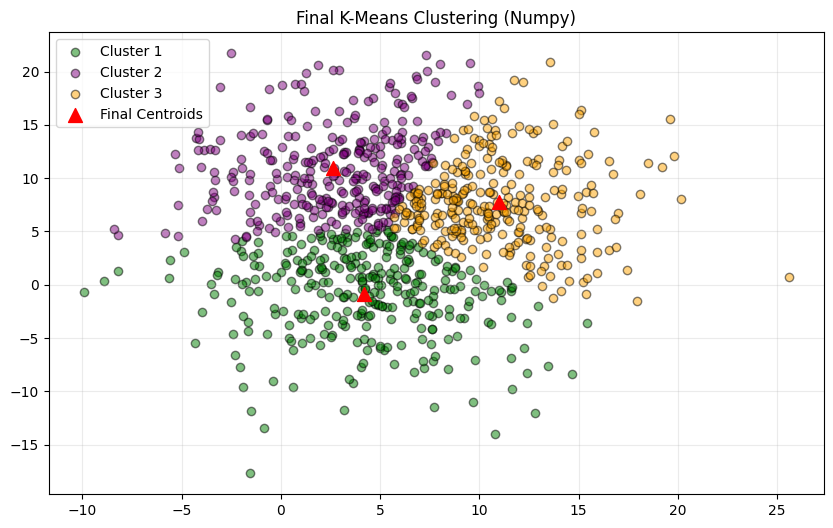

In [155]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, cluster in enumerate(final_clusters_np):
    ax.scatter(cluster[:, 0], cluster[:, 1], color=COLORS[i], alpha=0.5, edgecolors='k', label=f"Cluster {i+1}")
ax.scatter(final_centroids_np[:, 0], final_centroids_np[:, 1], color='red', marker='^', s=100, label="Final Centroids")
ax.set_title("Final K-Means Clustering (Numpy)")
ax.legend()
ax.grid(True, alpha=0.25)

plt.savefig('./data/kmeans_final_clusters_np.png')